In [38]:
import os
import sys
import numpy as np
import pandas as pd
import keras
import string
import matplotlib.pyplot as plt

In [39]:
MAX_SEQUENCE_LEN = 100
MAX_VOCAB_SIZE = 5000
BATCH_SIZE = 128
EPOCHS = 2500
VALIDATION_SPLIT = 0.25
EMBEDDING_DIM = 100
LATENT_DIM = 20

In [40]:
with open('robert_frost.txt') as f:
    text = f.readlines()

In [41]:
input_lines = []
output_lines = []
for line in text:
    line = line.rstrip()
    if not line:
        continue
        
    input_line = '<sos> ' + line
    input_lines.append(input_line)
    
    output_line = line + ' <eos>'
    output_lines.append(output_line)
    
all_lines = input_lines + output_lines

In [42]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)

input_sequences = tokenizer.texts_to_sequences(input_lines)
output_sequences = tokenizer.texts_to_sequences(output_lines)

max_seq = max((len(seq) for seq in input_sequences))
print(f'Maximum sequence length is: {max_seq}')

Maximum sequence length is: 12


In [43]:
word2index = tokenizer.word_index
print(f'Total {len(word2index)} unique tokens found')

Total 3056 unique tokens found


In [44]:
assert('<sos>' in word2index)
assert('<eos>' in word2index)

In [45]:
word2vec = {}
with open(f'glove.6B.{EMBEDDING_DIM}d.txt', encoding='utf-8') as f:
    for line in f:
        entries = line.split()
        word = entries[0]
        vector = np.asarray(entries[1:], dtype='float32')
        word2vec[word] = vector
print(f'Total {len(word2vec)} word vectors')

Total 400000 word vectors


In [46]:
word_count = min(MAX_VOCAB_SIZE, len(word2index)+1)
word_embedding = np.zeros((word_count, EMBEDDING_DIM))
for word, index in word2index.items():
    if index < MAX_VOCAB_SIZE:
        entry = word2vec.get(word)
        if entry is not None:
            word_embedding[index] = entry

In [47]:
MAX_SEQUENCE_LEN = min(MAX_SEQUENCE_LEN, max_seq)

input_sequences = pad_sequences(input_sequences, maxlen=MAX_SEQUENCE_LEN, padding='post')
output_sequences = pad_sequences(output_sequences, maxlen=MAX_SEQUENCE_LEN, padding='post')
print(f'Shapes: {input_sequences.shape} and {output_sequences.shape}')

Shapes: (1436, 12) and (1436, 12)


In [48]:
one_hot_targets = np.zeros((len(output_sequences), MAX_SEQUENCE_LEN, word_count))
for line, sequence in enumerate(output_sequences):
    for index, word_index in enumerate(sequence):
        if word_index > 0:
            one_hot_targets[line, index, word_index] = 1

In [49]:
from keras.models import Input, Model
from keras.layers import Dense, Embedding, LSTM
from keras.optimizers import Adam

embedding_layer = Embedding(word_count, EMBEDDING_DIM, weights=[word_embedding])

input_seq = Input((MAX_SEQUENCE_LEN,))
initial_h = Input((LATENT_DIM,))
initial_c = Input((LATENT_DIM,))

x = embedding_layer(input_seq)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x,_,_ = lstm(x, initial_state=[initial_h, initial_c])
dense_layer = Dense(word_count, activation='softmax')
output = dense_layer(x)

model = Model([input_seq, initial_h, initial_c], output)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 12)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 12, 100)      305700      input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 20)           0                                            
____________________________________________________________________________________________

In [50]:
initial_state_values = np.zeros((len(input_sequences), LATENT_DIM))
history = model.fit([input_sequences, initial_state_values, initial_state_values], 
                    one_hot_targets,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=VALIDATION_SPLIT)

C:\Users\Riju\Miniconda3\envs\Tensorflow-GPU\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1077 samples, validate on 359 samples
Epoch 1/2500
1077/1077 [==============================] - 4s 3ms/step - loss: 5.6802 - accuracy: 0.0171 - val_loss: 5.2319 - val_accuracy: 0.0193
Epoch 2/2500
1077/1077 [==============================] - 1s 1ms/step - loss: 5.2816 - accuracy: 0.0321 - val_loss: 4.8939 - val_accuracy: 0.0223
Epoch 3/2500
1077/1077 [==============================] - 1s 998us/step - loss: 4.8402 - accuracy: 0.0343 - val_loss: 4.6723 - val_accuracy: 0.0223
Epoch 4/2500
1077/1077 [==============================] - 3s 3ms/step - loss: 4.5635 - accuracy: 0.0343 - val_loss: 4.5865 - val_accuracy: 0.0223
Epoch 5/2500
1077/1077 [==============================] - 3s 3ms/step - loss: 4.4300 - accuracy: 0.0654 - val_loss: 4.5728 - val_accuracy: 0.0833
Epoch 6/2500
1077/1077 [==============================] - 3s 3ms/step - loss: 4.3825 - accuracy: 0.0833 - val_loss: 4.5904 - val_accuracy: 0.0833
Epoch 7/2500
1077/1077 [==============================] - 4s 3ms/step - los

1077/1077 [==============================] - 1s 563us/step - loss: 2.6028 - accuracy: 0.2327 - val_loss: 4.9209 - val_accuracy: 0.0952
Epoch 112/2500
1077/1077 [==============================] - 1s 572us/step - loss: 2.5912 - accuracy: 0.2343 - val_loss: 4.9309 - val_accuracy: 0.0935
Epoch 113/2500
1077/1077 [==============================] - 1s 566us/step - loss: 2.5805 - accuracy: 0.2354 - val_loss: 4.9353 - val_accuracy: 0.0947
Epoch 114/2500
1077/1077 [==============================] - 1s 561us/step - loss: 2.5695 - accuracy: 0.2373 - val_loss: 4.9396 - val_accuracy: 0.0952
Epoch 115/2500
1077/1077 [==============================] - 1s 563us/step - loss: 2.5602 - accuracy: 0.2382 - val_loss: 4.9443 - val_accuracy: 0.0942
Epoch 116/2500
1077/1077 [==============================] - 1s 568us/step - loss: 2.5489 - accuracy: 0.2394 - val_loss: 4.9558 - val_accuracy: 0.0940
Epoch 117/2500
1077/1077 [==============================] - 1s 563us/step - loss: 2.5390 - accuracy: 0.2413 - val_l

Epoch 166/2500
1077/1077 [==============================] - 1s 562us/step - loss: 2.1573 - accuracy: 0.2911 - val_loss: 5.2443 - val_accuracy: 0.0933
Epoch 167/2500
1077/1077 [==============================] - 1s 562us/step - loss: 2.1520 - accuracy: 0.2903 - val_loss: 5.2498 - val_accuracy: 0.0919
Epoch 168/2500
1077/1077 [==============================] - 1s 563us/step - loss: 2.1473 - accuracy: 0.2926 - val_loss: 5.2565 - val_accuracy: 0.0917
Epoch 169/2500
1077/1077 [==============================] - 1s 565us/step - loss: 2.1409 - accuracy: 0.2944 - val_loss: 5.2608 - val_accuracy: 0.0917
Epoch 170/2500
1077/1077 [==============================] - 1s 563us/step - loss: 2.1347 - accuracy: 0.2932 - val_loss: 5.2684 - val_accuracy: 0.0917
Epoch 171/2500
1077/1077 [==============================] - 1s 573us/step - loss: 2.1278 - accuracy: 0.2944 - val_loss: 5.2720 - val_accuracy: 0.0924
Epoch 172/2500
1077/1077 [==============================] - 1s 574us/step - loss: 2.1208 - accuracy:

Epoch 275/2500
1077/1077 [==============================] - 1s 568us/step - loss: 1.7324 - accuracy: 0.3565 - val_loss: 5.7775 - val_accuracy: 0.0808
Epoch 276/2500
1077/1077 [==============================] - 1s 560us/step - loss: 1.7295 - accuracy: 0.3546 - val_loss: 5.7802 - val_accuracy: 0.0822
Epoch 277/2500
1077/1077 [==============================] - 1s 566us/step - loss: 1.7259 - accuracy: 0.3568 - val_loss: 5.7786 - val_accuracy: 0.0831
Epoch 278/2500
1077/1077 [==============================] - 1s 564us/step - loss: 1.7233 - accuracy: 0.3563 - val_loss: 5.7860 - val_accuracy: 0.0819
Epoch 279/2500
1077/1077 [==============================] - 1s 567us/step - loss: 1.7240 - accuracy: 0.3569 - val_loss: 5.7848 - val_accuracy: 0.0824
Epoch 280/2500
1077/1077 [==============================] - 1s 564us/step - loss: 1.7222 - accuracy: 0.3553 - val_loss: 5.8027 - val_accuracy: 0.0831
Epoch 281/2500
1077/1077 [==============================] - 1s 567us/step - loss: 1.7183 - accuracy:

Epoch 384/2500
1077/1077 [==============================] - 1s 567us/step - loss: 1.4945 - accuracy: 0.4000 - val_loss: 6.1581 - val_accuracy: 0.0764
Epoch 385/2500
1077/1077 [==============================] - 1s 564us/step - loss: 1.4941 - accuracy: 0.3985 - val_loss: 6.1661 - val_accuracy: 0.0764
Epoch 386/2500
1077/1077 [==============================] - 1s 564us/step - loss: 1.4933 - accuracy: 0.3989 - val_loss: 6.1602 - val_accuracy: 0.0759
Epoch 387/2500
1077/1077 [==============================] - 1s 561us/step - loss: 1.4914 - accuracy: 0.4010 - val_loss: 6.1930 - val_accuracy: 0.0731
Epoch 388/2500
1077/1077 [==============================] - 1s 564us/step - loss: 1.4984 - accuracy: 0.3969 - val_loss: 6.1630 - val_accuracy: 0.0745
Epoch 389/2500
1077/1077 [==============================] - 1s 563us/step - loss: 1.4960 - accuracy: 0.3964 - val_loss: 6.1754 - val_accuracy: 0.0759
Epoch 390/2500
1077/1077 [==============================] - 1s 566us/step - loss: 1.4916 - accuracy:

Epoch 493/2500
1077/1077 [==============================] - 1s 563us/step - loss: 1.3242 - accuracy: 0.4310 - val_loss: 6.4647 - val_accuracy: 0.0696
Epoch 494/2500
1077/1077 [==============================] - 1s 569us/step - loss: 1.3241 - accuracy: 0.4311 - val_loss: 6.4742 - val_accuracy: 0.0694
Epoch 495/2500
1077/1077 [==============================] - 1s 564us/step - loss: 1.3234 - accuracy: 0.4309 - val_loss: 6.4724 - val_accuracy: 0.0694
Epoch 496/2500
1077/1077 [==============================] - 1s 567us/step - loss: 1.3248 - accuracy: 0.4287 - val_loss: 6.4700 - val_accuracy: 0.0694
Epoch 497/2500
1077/1077 [==============================] - 1s 566us/step - loss: 1.3233 - accuracy: 0.4307 - val_loss: 6.4760 - val_accuracy: 0.0696
Epoch 498/2500
1077/1077 [==============================] - 1s 561us/step - loss: 1.3220 - accuracy: 0.4308 - val_loss: 6.4671 - val_accuracy: 0.0696
Epoch 499/2500
1077/1077 [==============================] - 1s 560us/step - loss: 1.3242 - accuracy:

Epoch 602/2500
1077/1077 [==============================] - 1s 563us/step - loss: 1.2089 - accuracy: 0.4548 - val_loss: 6.7054 - val_accuracy: 0.0671
Epoch 603/2500
1077/1077 [==============================] - 1s 565us/step - loss: 1.2071 - accuracy: 0.4550 - val_loss: 6.7042 - val_accuracy: 0.0666
Epoch 604/2500
1077/1077 [==============================] - 1s 566us/step - loss: 1.2059 - accuracy: 0.4546 - val_loss: 6.7105 - val_accuracy: 0.0671
Epoch 605/2500
1077/1077 [==============================] - 1s 560us/step - loss: 1.2044 - accuracy: 0.4556 - val_loss: 6.7140 - val_accuracy: 0.0652
Epoch 606/2500
1077/1077 [==============================] - 1s 563us/step - loss: 1.2023 - accuracy: 0.4581 - val_loss: 6.7207 - val_accuracy: 0.0657
Epoch 607/2500
1077/1077 [==============================] - 1s 563us/step - loss: 1.2016 - accuracy: 0.4564 - val_loss: 6.7085 - val_accuracy: 0.0675
Epoch 608/2500
1077/1077 [==============================] - 1s 564us/step - loss: 1.1989 - accuracy:

Epoch 711/2500
1077/1077 [==============================] - 1s 564us/step - loss: 1.1134 - accuracy: 0.4762 - val_loss: 6.8955 - val_accuracy: 0.0652
Epoch 712/2500
1077/1077 [==============================] - 1s 563us/step - loss: 1.1128 - accuracy: 0.4772 - val_loss: 6.8984 - val_accuracy: 0.0662
Epoch 713/2500
1077/1077 [==============================] - 1s 566us/step - loss: 1.1106 - accuracy: 0.4779 - val_loss: 6.9133 - val_accuracy: 0.0643
Epoch 714/2500
1077/1077 [==============================] - 1s 567us/step - loss: 1.1108 - accuracy: 0.4764 - val_loss: 6.9092 - val_accuracy: 0.0636
Epoch 715/2500
1077/1077 [==============================] - 1s 565us/step - loss: 1.1097 - accuracy: 0.4776 - val_loss: 6.9174 - val_accuracy: 0.0634
Epoch 716/2500
1077/1077 [==============================] - 1s 567us/step - loss: 1.1077 - accuracy: 0.4760 - val_loss: 6.9176 - val_accuracy: 0.0648
Epoch 717/2500
1077/1077 [==============================] - 1s 565us/step - loss: 1.1066 - accuracy:

Epoch 820/2500
1077/1077 [==============================] - 1s 570us/step - loss: 1.0450 - accuracy: 0.4913 - val_loss: 7.0645 - val_accuracy: 0.0624
Epoch 821/2500
1077/1077 [==============================] - 1s 566us/step - loss: 1.0688 - accuracy: 0.4833 - val_loss: 7.0533 - val_accuracy: 0.0645
Epoch 822/2500
1077/1077 [==============================] - 1s 566us/step - loss: 1.0642 - accuracy: 0.4858 - val_loss: 7.0861 - val_accuracy: 0.0604
Epoch 823/2500
1077/1077 [==============================] - 1s 564us/step - loss: 1.0580 - accuracy: 0.4872 - val_loss: 7.0689 - val_accuracy: 0.0624
Epoch 824/2500
1077/1077 [==============================] - 1s 568us/step - loss: 1.0535 - accuracy: 0.4876 - val_loss: 7.0643 - val_accuracy: 0.0627
Epoch 825/2500
1077/1077 [==============================] - 1s 561us/step - loss: 1.0515 - accuracy: 0.4893 - val_loss: 7.0630 - val_accuracy: 0.0629
Epoch 826/2500
1077/1077 [==============================] - 1s 570us/step - loss: 1.0452 - accuracy:

Epoch 929/2500
1077/1077 [==============================] - 1s 585us/step - loss: 0.9881 - accuracy: 0.5040 - val_loss: 7.2174 - val_accuracy: 0.0617
Epoch 930/2500
1077/1077 [==============================] - 1s 584us/step - loss: 0.9870 - accuracy: 0.5040 - val_loss: 7.2110 - val_accuracy: 0.0629
Epoch 931/2500
1077/1077 [==============================] - 1s 585us/step - loss: 0.9872 - accuracy: 0.5044 - val_loss: 7.2102 - val_accuracy: 0.0627
Epoch 932/2500
1077/1077 [==============================] - 1s 581us/step - loss: 0.9867 - accuracy: 0.5048 - val_loss: 7.2203 - val_accuracy: 0.0622
Epoch 933/2500
1077/1077 [==============================] - 1s 583us/step - loss: 0.9863 - accuracy: 0.5034 - val_loss: 7.2246 - val_accuracy: 0.0613
Epoch 934/2500
1077/1077 [==============================] - 1s 583us/step - loss: 0.9865 - accuracy: 0.5037 - val_loss: 7.2203 - val_accuracy: 0.0634
Epoch 935/2500
1077/1077 [==============================] - 1s 582us/step - loss: 0.9889 - accuracy:

1077/1077 [==============================] - 1s 579us/step - loss: 0.9427 - accuracy: 0.5122 - val_loss: 7.3391 - val_accuracy: 0.0610
Epoch 1038/2500
1077/1077 [==============================] - 1s 583us/step - loss: 0.9428 - accuracy: 0.5110 - val_loss: 7.3419 - val_accuracy: 0.0606
Epoch 1039/2500
1077/1077 [==============================] - 1s 583us/step - loss: 0.9414 - accuracy: 0.5122 - val_loss: 7.3414 - val_accuracy: 0.0604
Epoch 1040/2500
1077/1077 [==============================] - 1s 580us/step - loss: 0.9432 - accuracy: 0.5123 - val_loss: 7.3450 - val_accuracy: 0.0620
Epoch 1041/2500
1077/1077 [==============================] - 1s 577us/step - loss: 0.9417 - accuracy: 0.5125 - val_loss: 7.3391 - val_accuracy: 0.0606
Epoch 1042/2500
1077/1077 [==============================] - 1s 585us/step - loss: 0.9443 - accuracy: 0.5111 - val_loss: 7.3599 - val_accuracy: 0.0597
Epoch 1043/2500
1077/1077 [==============================] - 1s 587us/step - loss: 0.9458 - accuracy: 0.5135 -

1077/1077 [==============================] - 1s 581us/step - loss: 0.9055 - accuracy: 0.5196 - val_loss: 7.4294 - val_accuracy: 0.0583
Epoch 1146/2500
1077/1077 [==============================] - 1s 576us/step - loss: 0.9044 - accuracy: 0.5213 - val_loss: 7.4356 - val_accuracy: 0.0576
Epoch 1147/2500
1077/1077 [==============================] - 1s 580us/step - loss: 0.9048 - accuracy: 0.5191 - val_loss: 7.4405 - val_accuracy: 0.0569
Epoch 1148/2500
1077/1077 [==============================] - 1s 577us/step - loss: 0.9058 - accuracy: 0.5189 - val_loss: 7.4239 - val_accuracy: 0.0578
Epoch 1149/2500
1077/1077 [==============================] - 1s 581us/step - loss: 0.9069 - accuracy: 0.5178 - val_loss: 7.4374 - val_accuracy: 0.0569
Epoch 1150/2500
1077/1077 [==============================] - 1s 583us/step - loss: 0.9055 - accuracy: 0.5197 - val_loss: 7.4339 - val_accuracy: 0.0585
Epoch 1151/2500
1077/1077 [==============================] - 1s 577us/step - loss: 0.9098 - accuracy: 0.5180 -

1077/1077 [==============================] - 1s 576us/step - loss: 0.8767 - accuracy: 0.5265 - val_loss: 7.5349 - val_accuracy: 0.0552
Epoch 1254/2500
1077/1077 [==============================] - 1s 574us/step - loss: 0.8781 - accuracy: 0.5268 - val_loss: 7.5310 - val_accuracy: 0.0541
Epoch 1255/2500
1077/1077 [==============================] - 1s 580us/step - loss: 0.8814 - accuracy: 0.5252 - val_loss: 7.5419 - val_accuracy: 0.0543
Epoch 1256/2500
1077/1077 [==============================] - 1s 580us/step - loss: 0.8807 - accuracy: 0.5253 - val_loss: 7.5377 - val_accuracy: 0.0545
Epoch 1257/2500
1077/1077 [==============================] - 1s 584us/step - loss: 0.8820 - accuracy: 0.5243 - val_loss: 7.5316 - val_accuracy: 0.0559
Epoch 1258/2500
1077/1077 [==============================] - 1s 602us/step - loss: 0.8835 - accuracy: 0.5242 - val_loss: 7.5253 - val_accuracy: 0.0548
Epoch 1259/2500
1077/1077 [==============================] - 1s 579us/step - loss: 0.8816 - accuracy: 0.5234 -

1077/1077 [==============================] - 1s 587us/step - loss: 0.8525 - accuracy: 0.5313 - val_loss: 7.6010 - val_accuracy: 0.0518
Epoch 1362/2500
1077/1077 [==============================] - 1s 589us/step - loss: 0.8549 - accuracy: 0.5323 - val_loss: 7.6304 - val_accuracy: 0.0501
Epoch 1363/2500
1077/1077 [==============================] - 1s 586us/step - loss: 0.8523 - accuracy: 0.5318 - val_loss: 7.6104 - val_accuracy: 0.0511
Epoch 1364/2500
1077/1077 [==============================] - 1s 593us/step - loss: 0.8550 - accuracy: 0.5319 - val_loss: 7.6286 - val_accuracy: 0.0518
Epoch 1365/2500
1077/1077 [==============================] - 1s 584us/step - loss: 0.8547 - accuracy: 0.5310 - val_loss: 7.6337 - val_accuracy: 0.0518
Epoch 1366/2500
1077/1077 [==============================] - 1s 583us/step - loss: 0.8538 - accuracy: 0.5333 - val_loss: 7.6326 - val_accuracy: 0.0508
Epoch 1367/2500
1077/1077 [==============================] - 1s 586us/step - loss: 0.8540 - accuracy: 0.5307 -

1077/1077 [==============================] - 1s 581us/step - loss: 0.8346 - accuracy: 0.5352 - val_loss: 7.6810 - val_accuracy: 0.0497
Epoch 1470/2500
1077/1077 [==============================] - 1s 581us/step - loss: 0.8331 - accuracy: 0.5361 - val_loss: 7.6885 - val_accuracy: 0.0478
Epoch 1471/2500
1077/1077 [==============================] - 1s 583us/step - loss: 0.8361 - accuracy: 0.5351 - val_loss: 7.6912 - val_accuracy: 0.0504
Epoch 1472/2500
1077/1077 [==============================] - 1s 583us/step - loss: 0.8357 - accuracy: 0.5354 - val_loss: 7.6988 - val_accuracy: 0.0485
Epoch 1473/2500
1077/1077 [==============================] - 1s 576us/step - loss: 0.8361 - accuracy: 0.5342 - val_loss: 7.6945 - val_accuracy: 0.0501
Epoch 1474/2500
1077/1077 [==============================] - 1s 576us/step - loss: 0.8421 - accuracy: 0.5310 - val_loss: 7.6900 - val_accuracy: 0.0515
Epoch 1475/2500
1077/1077 [==============================] - 1s 577us/step - loss: 0.8413 - accuracy: 0.5325 -

1077/1077 [==============================] - 1s 577us/step - loss: 0.8186 - accuracy: 0.5390 - val_loss: 7.7949 - val_accuracy: 0.0494
Epoch 1578/2500
1077/1077 [==============================] - 1s 581us/step - loss: 0.8210 - accuracy: 0.5373 - val_loss: 7.7740 - val_accuracy: 0.0499
Epoch 1579/2500
1077/1077 [==============================] - 1s 587us/step - loss: 0.8243 - accuracy: 0.5379 - val_loss: 7.8131 - val_accuracy: 0.0492
Epoch 1580/2500
1077/1077 [==============================] - 1s 579us/step - loss: 0.8360 - accuracy: 0.5321 - val_loss: 7.7791 - val_accuracy: 0.0511
Epoch 1581/2500
1077/1077 [==============================] - 1s 647us/step - loss: 0.8347 - accuracy: 0.5326 - val_loss: 7.7764 - val_accuracy: 0.0499
Epoch 1582/2500
1077/1077 [==============================] - 1s 582us/step - loss: 0.8410 - accuracy: 0.5296 - val_loss: 7.7923 - val_accuracy: 0.0511
Epoch 1583/2500
1077/1077 [==============================] - 1s 587us/step - loss: 0.8424 - accuracy: 0.5304 -

1077/1077 [==============================] - 1s 566us/step - loss: 0.7925 - accuracy: 0.5441 - val_loss: 7.8612 - val_accuracy: 0.0471
Epoch 1686/2500
1077/1077 [==============================] - 1s 590us/step - loss: 0.7931 - accuracy: 0.5436 - val_loss: 7.8800 - val_accuracy: 0.0476
Epoch 1687/2500
1077/1077 [==============================] - 1s 572us/step - loss: 0.7913 - accuracy: 0.5440 - val_loss: 7.8675 - val_accuracy: 0.0474
Epoch 1688/2500
1077/1077 [==============================] - 1s 564us/step - loss: 0.7918 - accuracy: 0.5439 - val_loss: 7.8772 - val_accuracy: 0.0483
Epoch 1689/2500
1077/1077 [==============================] - 1s 569us/step - loss: 0.7908 - accuracy: 0.5453 - val_loss: 7.8729 - val_accuracy: 0.0462
Epoch 1690/2500
1077/1077 [==============================] - 1s 570us/step - loss: 0.7891 - accuracy: 0.5452 - val_loss: 7.8814 - val_accuracy: 0.0471
Epoch 1691/2500
1077/1077 [==============================] - 1s 570us/step - loss: 0.7892 - accuracy: 0.5453 -

1077/1077 [==============================] - 1s 582us/step - loss: 0.7823 - accuracy: 0.5467 - val_loss: 7.8871 - val_accuracy: 0.0460
Epoch 1794/2500
1077/1077 [==============================] - 1s 579us/step - loss: 0.7810 - accuracy: 0.5463 - val_loss: 7.8997 - val_accuracy: 0.0460
Epoch 1795/2500
1077/1077 [==============================] - 1s 581us/step - loss: 0.7799 - accuracy: 0.5461 - val_loss: 7.8803 - val_accuracy: 0.0469
Epoch 1796/2500
1077/1077 [==============================] - 1s 583us/step - loss: 0.7805 - accuracy: 0.5462 - val_loss: 7.8920 - val_accuracy: 0.0464
Epoch 1797/2500
1077/1077 [==============================] - 1s 591us/step - loss: 0.7807 - accuracy: 0.5463 - val_loss: 7.8935 - val_accuracy: 0.0460
Epoch 1798/2500
1077/1077 [==============================] - 1s 576us/step - loss: 0.7795 - accuracy: 0.5467 - val_loss: 7.8862 - val_accuracy: 0.0462
Epoch 1799/2500
1077/1077 [==============================] - 1s 591us/step - loss: 0.7827 - accuracy: 0.5460 -

1077/1077 [==============================] - 1s 601us/step - loss: 0.7615 - accuracy: 0.5504 - val_loss: 7.9651 - val_accuracy: 0.0455
Epoch 1902/2500
1077/1077 [==============================] - 1s 584us/step - loss: 0.7605 - accuracy: 0.5510 - val_loss: 7.9568 - val_accuracy: 0.0455
Epoch 1903/2500
1077/1077 [==============================] - 1s 586us/step - loss: 0.7611 - accuracy: 0.5513 - val_loss: 7.9638 - val_accuracy: 0.0453
Epoch 1904/2500
1077/1077 [==============================] - 1s 576us/step - loss: 0.7608 - accuracy: 0.5517 - val_loss: 7.9632 - val_accuracy: 0.0443
Epoch 1905/2500
1077/1077 [==============================] - 1s 581us/step - loss: 0.7604 - accuracy: 0.5525 - val_loss: 7.9649 - val_accuracy: 0.0446
Epoch 1906/2500
1077/1077 [==============================] - 1s 622us/step - loss: 0.7608 - accuracy: 0.5487 - val_loss: 7.9672 - val_accuracy: 0.0427
Epoch 1907/2500
1077/1077 [==============================] - 1s 588us/step - loss: 0.7603 - accuracy: 0.5514 -

1077/1077 [==============================] - 1s 616us/step - loss: 0.7546 - accuracy: 0.5521 - val_loss: 8.0286 - val_accuracy: 0.0439
Epoch 2010/2500
1077/1077 [==============================] - 1s 586us/step - loss: 0.7595 - accuracy: 0.5504 - val_loss: 8.0196 - val_accuracy: 0.0450
Epoch 2011/2500
1077/1077 [==============================] - 1s 587us/step - loss: 0.7557 - accuracy: 0.5520 - val_loss: 8.0188 - val_accuracy: 0.0453
Epoch 2012/2500
1077/1077 [==============================] - 1s 590us/step - loss: 0.7539 - accuracy: 0.5518 - val_loss: 8.0336 - val_accuracy: 0.0429
Epoch 2013/2500
1077/1077 [==============================] - 1s 587us/step - loss: 0.7534 - accuracy: 0.5535 - val_loss: 8.0312 - val_accuracy: 0.0441
Epoch 2014/2500
1077/1077 [==============================] - 1s 584us/step - loss: 0.7578 - accuracy: 0.5509 - val_loss: 8.0102 - val_accuracy: 0.0441
Epoch 2015/2500
1077/1077 [==============================] - 1s 577us/step - loss: 0.7619 - accuracy: 0.5501 -

1077/1077 [==============================] - 1s 585us/step - loss: 0.7836 - accuracy: 0.5427 - val_loss: 8.0389 - val_accuracy: 0.0448
Epoch 2118/2500
1077/1077 [==============================] - 1s 585us/step - loss: 0.7790 - accuracy: 0.5431 - val_loss: 8.0454 - val_accuracy: 0.0441
Epoch 2119/2500
1077/1077 [==============================] - 1s 580us/step - loss: 0.7832 - accuracy: 0.5416 - val_loss: 8.0333 - val_accuracy: 0.0467
Epoch 2120/2500
1077/1077 [==============================] - 1s 583us/step - loss: 0.7851 - accuracy: 0.5410 - val_loss: 8.0649 - val_accuracy: 0.0453
Epoch 2121/2500
1077/1077 [==============================] - 1s 582us/step - loss: 0.7977 - accuracy: 0.5404 - val_loss: 8.0048 - val_accuracy: 0.0499
Epoch 2122/2500
1077/1077 [==============================] - 1s 584us/step - loss: 0.8039 - accuracy: 0.5366 - val_loss: 8.0370 - val_accuracy: 0.0460
Epoch 2123/2500
1077/1077 [==============================] - 1s 586us/step - loss: 0.7904 - accuracy: 0.5411 -

1077/1077 [==============================] - 1s 585us/step - loss: 0.7314 - accuracy: 0.5559 - val_loss: 8.0766 - val_accuracy: 0.0462
Epoch 2226/2500
1077/1077 [==============================] - 1s 583us/step - loss: 0.7299 - accuracy: 0.5553 - val_loss: 8.0972 - val_accuracy: 0.0474
Epoch 2227/2500
1077/1077 [==============================] - 1s 578us/step - loss: 0.7308 - accuracy: 0.5556 - val_loss: 8.0816 - val_accuracy: 0.0462
Epoch 2228/2500
1077/1077 [==============================] - 1s 595us/step - loss: 0.7282 - accuracy: 0.5576 - val_loss: 8.0876 - val_accuracy: 0.0453
Epoch 2229/2500
1077/1077 [==============================] - 1s 583us/step - loss: 0.7278 - accuracy: 0.5577 - val_loss: 8.0809 - val_accuracy: 0.0471
Epoch 2230/2500
1077/1077 [==============================] - 1s 585us/step - loss: 0.7270 - accuracy: 0.5583 - val_loss: 8.0989 - val_accuracy: 0.0467
Epoch 2231/2500
1077/1077 [==============================] - 1s 586us/step - loss: 0.7269 - accuracy: 0.5576 -

1077/1077 [==============================] - 1s 602us/step - loss: 0.7423 - accuracy: 0.5526 - val_loss: 8.1201 - val_accuracy: 0.0441
Epoch 2334/2500
1077/1077 [==============================] - 1s 597us/step - loss: 0.7456 - accuracy: 0.5517 - val_loss: 8.1358 - val_accuracy: 0.0432
Epoch 2335/2500
1077/1077 [==============================] - 1s 588us/step - loss: 0.7431 - accuracy: 0.5525 - val_loss: 8.1255 - val_accuracy: 0.0455
Epoch 2336/2500
1077/1077 [==============================] - 1s 586us/step - loss: 0.7420 - accuracy: 0.5521 - val_loss: 8.1403 - val_accuracy: 0.0432
Epoch 2337/2500
1077/1077 [==============================] - 1s 591us/step - loss: 0.7381 - accuracy: 0.5539 - val_loss: 8.1234 - val_accuracy: 0.0450
Epoch 2338/2500
1077/1077 [==============================] - 1s 601us/step - loss: 0.7389 - accuracy: 0.5539 - val_loss: 8.1407 - val_accuracy: 0.0429
Epoch 2339/2500
1077/1077 [==============================] - 1s 591us/step - loss: 0.7397 - accuracy: 0.5542 -

1077/1077 [==============================] - 1s 587us/step - loss: 0.7155 - accuracy: 0.5592 - val_loss: 8.1624 - val_accuracy: 0.0453
Epoch 2442/2500
1077/1077 [==============================] - 1s 584us/step - loss: 0.7150 - accuracy: 0.5603 - val_loss: 8.1781 - val_accuracy: 0.0450
Epoch 2443/2500
1077/1077 [==============================] - 1s 580us/step - loss: 0.7159 - accuracy: 0.5599 - val_loss: 8.1709 - val_accuracy: 0.0460
Epoch 2444/2500
1077/1077 [==============================] - 1s 579us/step - loss: 0.7150 - accuracy: 0.5592 - val_loss: 8.1726 - val_accuracy: 0.0432
Epoch 2445/2500
1077/1077 [==============================] - 1s 580us/step - loss: 0.7163 - accuracy: 0.5599 - val_loss: 8.1632 - val_accuracy: 0.0450
Epoch 2446/2500
1077/1077 [==============================] - 1s 582us/step - loss: 0.7149 - accuracy: 0.5607 - val_loss: 8.1717 - val_accuracy: 0.0443
Epoch 2447/2500
1077/1077 [==============================] - 1s 582us/step - loss: 0.7160 - accuracy: 0.5596 -

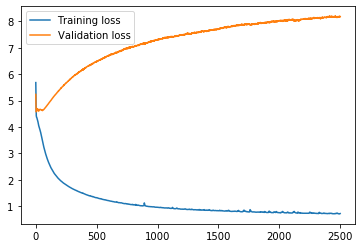

In [52]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

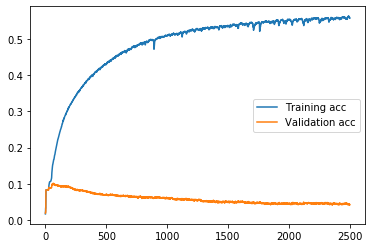

In [54]:
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.legend()
plt.show()

In [56]:
input_pred = Input((1,))
x = embedding_layer(input_pred)
x, h, c = lstm(x, initial_state=[initial_h, initial_c])
output_pred = dense_layer(x)

prediction_model = Model([input_pred, initial_h, initial_c], [output_pred, h, c])

In [57]:
index2word = {value: key for key, value in word2index.items()}

In [58]:
def generate_line():
    input_word = np.array([[word2index['<sos>']]])
    h = np.zeros((1, LATENT_DIM))
    c = np.zeros((1,LATENT_DIM))
    
    eos = word2index['<eos>']
    
    output_line=[]
    
    for _ in range(MAX_SEQUENCE_LEN):
        output, h, c = prediction_model.predict([input_word, h, c])
        prob = output[0,0]
        if np.argmax(prob)==0:
            print('Should not have happened')
            
        prob[0]=0
        prob = prob/prob.sum()
        word_index_sampled = np.random.choice(len(prob), p=prob)
        if word_index_sampled==eos:
            break
            
        input_word[0,0] = word_index_sampled
        
        word_sampled = index2word.get(word_index_sampled, f'<Bullshit> {word_index_sampled}')
        output_line.append(word_sampled)
        
    return ' '.join(output_line)

In [59]:
for _ in range(4):
    print(generate_line())

i could see nothing. 'toffile, i that when earth some strangeness out
about where henry hudson's gone,
ten million silver lizards out of snow!
speaking or singing, and the band-music playing.
